# Image data augmentation

In [ ]:
import numpy as np
import tensorflow as tf
import zipfile
import itertools as it
import matplotlib.pyplot as plt
import requests
import random
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import  Sequence

In [ ]:
# The train_.zip and quasars.zip compressed files should be uploaded into this notebook in order to run the rest of the cells
# In this cell we extract the names of the image files to sample them

with zipfile.ZipFile("/content/train_.zip", "r") as zip_data:
    content_list = zip_data.namelist()
    for folder in ['train_/GALAXY/', 'train_/STAR/', 'train_/QSO/']:
        content_list.remove(folder)

with zipfile.ZipFile("/content/quasars.zip", "r") as zip_data:
    augmented_quasars_names = zip_data.namelist()
    augmented_quasars_names.remove('images.qso/')

def access_image(name, content_list):
    with zipfile.ZipFile("/content/train_.zip", "r") as zip_data:
        return np.array(Image.open(zip_data.open(name)), np.uint8)

In [ ]:
# This cell is used to know the amount of observations of the three classes

g_images = [name_file for name_file in content_list if 'GALAXY' in name_file]
q_images = [name_file for name_file in content_list if 'QSO' in name_file]
s_images = [name_file for name_file in content_list if 'STAR' in name_file]

print(f'Number of star images: {len(s_images)}. Number of galaxy images: {len(g_images)}. Number of quasar images: {len(q_images)}')

Number of star images: 4152. Number of galaxy images: 4998. Number of quasar images: 850


In [ ]:
# Undersampling stars and galaxies

random.seed(0)
g_images_under = random.sample(g_images, 4000)
s_images_under = random.sample(s_images, 4000)

print(f'Number of star images: {len(s_images_under)}. Number of galaxy images: {len(g_images_under)}. Number of quasar images: {len(q_images)}')

Number of star images: 4000. Number of galaxy images: 4000. Number of quasar images: 850


In [ ]:
# Separating between train and test sets

random.seed(0)
g_training = random.sample(g_images_under, 3400)
s_training = random.sample(s_images_under, 3400)
q_training = random.sample(q_images, 250)

g_testing = [name for name in g_images_under if name not in g_training]
s_testing = [name for name in s_images_under if name not in s_training]
q_testing = [name for name in q_images if name not in q_training]

print(len(g_testing), len(s_testing), len(q_testing))
print(len(g_training), len(s_training), len(q_training))

600 600 600
3400 3400 250


In [ ]:
# In this cell we extract the original and augmented images from the zip files

with zipfile.ZipFile("/content/train_.zip", "r") as zip_data:
    labels_training = []
    for _, name_file in enumerate(g_training + s_training + q_training):
        img_bytes = zip_data.open(name_file)
        img_data = Image.open(img_bytes)
        image_as_array = np.array(img_data, np.uint8)
        if _ == 0:
            data_training = image_as_array[np.newaxis, :]
        else:
            data_training = np.concatenate((data_training, image_as_array[np.newaxis, :]))
        if 'GALAXY' in name_file:
            labels_training.append('GALAXY')
        elif 'QSO' in name_file:
            labels_training.append('QSO')
        elif 'STAR' in name_file:
            labels_training.append('STAR')

    labels_testing = []
    for _, name_file in enumerate(g_testing + s_testing + q_testing):
        img_bytes = zip_data.open(name_file)
        img_data = Image.open(img_bytes)
        image_as_array = np.array(img_data, np.uint8)
        if _ == 0:
            data_testing = image_as_array[np.newaxis, :]
        else:
            data_testing = np.concatenate((data_testing, image_as_array[np.newaxis, :]))
        if 'GALAXY' in name_file:
            labels_testing.append('GALAXY')
        elif 'QSO' in name_file:
            labels_testing.append('QSO')
        elif 'STAR' in name_file:
            labels_testing.append('STAR')

with zipfile.ZipFile("/content/quasars.zip", "r") as zip_data:
    labels_quasars_training = len(augmented_quasars_names)*['QSO']
    for _, name_file in enumerate(augmented_quasars_names):
        img_bytes = zip_data.open(name_file)
        img_data = Image.open(img_bytes)
        image_as_array = np.array(img_data, np.uint8)
        if _ == 0:
            data_training_qso = image_as_array[np.newaxis, :]
        else:
            data_training_qso = np.concatenate((data_training_qso, image_as_array[np.newaxis, :]))

In [ ]:
# We remove the additional fourth channel from the png images
data_training_qso_3channels = data_training_qso[:, :, :, :3]

# We add the augmented images to the main matrices
data_training_with_augmentations = np.concatenate((data_training, data_training_qso_3channels))
labels_training_with_augmentations = np.concatenate((labels_training, labels_quasars_training))

# Preprocessing of data
labels_training_with_augmentations = np.array(labels_training_with_augmentations)
labels_testing = np.array(labels_testing)

shuffler_training = np.random.RandomState(seed=10).permutation(data_training_with_augmentations.shape[0])
shuffler_testing = np.random.RandomState(seed=10).permutation(data_testing.shape[0])

y_train_not_encoded = labels_training_with_augmentations[shuffler_training]
y_train_encoded = np.unique(y_train_not_encoded, return_inverse=True)[1]

y_test_not_encoded = labels_testing[shuffler_testing]
y_test_encoded = np.unique(y_test_not_encoded, return_inverse=True)[1]

x_train = data_training_with_augmentations[shuffler_training]
x_train = x_train.astype('float32')
x_train /= 255 # Normalizing in a 0 to 1 range

x_test = data_testing[shuffler_testing]
x_test = x_test.astype('float32')
x_test /= 255 # Normalizing in a 0 to 1 range

n_classes = 3
y_train = np_utils.to_categorical(y_train_encoded, n_classes)   # [Galaxy, Quasar, Star]
y_test = np_utils.to_categorical(y_test_encoded, n_classes)     # [Galaxy, Quasar, Star]

In [ ]:
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(128, 128, 3)))

# convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(3, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test),)

Epoch 1/10
75/75 [==============================] - 38s 357ms/step - loss: 0.3019 - accuracy: 0.9013 - val_loss: 0.8541 - val_accuracy: 0.6850
Epoch 2/10
75/75 [==============================] - 24s 320ms/step - loss: 0.1431 - accuracy: 0.9572 - val_loss: 0.6118 - val_accuracy: 0.7833
Epoch 3/10
75/75 [==============================] - 24s 316ms/step - loss: 0.1027 - accuracy: 0.9691 - val_loss: 0.6495 - val_accuracy: 0.7683
Epoch 4/10
75/75 [==============================] - 24s 314ms/step - loss: 0.0998 - accuracy: 0.9704 - val_loss: 1.1028 - val_accuracy: 0.6594
Epoch 5/10
75/75 [==============================] - 24s 314ms/step - loss: 0.0821 - accuracy: 0.9745 - val_loss: 0.5255 - val_accuracy: 0.8450
Epoch 6/10
75/75 [==============================] - 24s 315ms/step - loss: 0.0726 - accuracy: 0.9779 - val_loss: 0.7167 - val_accuracy: 0.7756
Epoch 7/10
75/75 [==============================] - 24s 315ms/step - loss: 0.0594 - accuracy: 0.9822 - val_loss: 0.7052 - val_accuracy: 0.8039

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 50)      1400      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 75)      33825     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 75)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 75)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 125)       84500     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 125)      0         
 2D)                                                    

In [ ]:
y_pred = model.predict(x_test)

y_pred_int = np.argmax(y_pred, axis=1)
y_test_int = np.argmax(y_test, axis=1)

result = confusion_matrix(y_test_int, y_pred_int, normalize='pred')

57/57 [==============================] - 2s 23ms/step


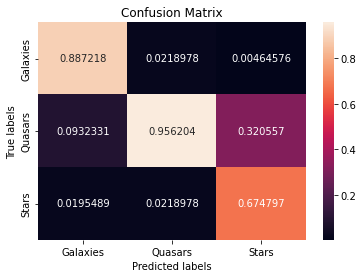

In [ ]:
ax= plt.subplot()
sns.heatmap(result, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Galaxies', 'Quasars', 'Stars']); ax.yaxis.set_ticklabels(['Galaxies', 'Quasars', 'Stars']);

In [ ]:
print(classification_report(y_test_int, y_pred_int, target_names=['Galaxies', 'Quasars', 'Stars']))

              precision    recall  f1-score   support

    Galaxies       0.89      0.98      0.93       600
     Quasars       0.96      0.44      0.60       600
       Stars       0.67      0.97      0.80       600

    accuracy                           0.80      1800
   macro avg       0.84      0.80      0.78      1800
weighted avg       0.84      0.80      0.78      1800



# Exploring the augmentations in quasar images

In [ ]:
image = access_image('train_/STAR/image_3679.jpg',content_list) # 3663 & 3671 are quasars

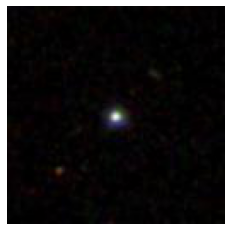

In [ ]:
image = img_to_array(image).astype(int)
data = np.expand_dims(image, 0)
plt.axis('off')
plt.imshow(data[0])

In [ ]:
def default_datagen(data):
  datagen = ImageDataGenerator(fill_mode='constant', dtype=int)
  datagen.fill_mode='nearest'
  datagen.horizontal_flip=True
  datagen.width_shift_range=0.2
  datagen.height_shift_range=0.2
  datagen.zoom_range=[0.8, 1.2]
  datagen.rotation_range=20
  datagen.shear_range=10
  gen_flow = datagen.flow(data)
  return gen_flow

In [ ]:
def plot_augmentation(genflow, data, n_rows=1, n_cols=5):
  n_images = n_rows * n_cols

  plt.figure(figsize=(n_cols*4, n_rows*3))
  for image_index in range(n_images):
    image = next(gen_flow)
    plt.subplot(n_rows, n_cols, image_index+1)
    plt.axis('off')
    plt.imshow(image[0], vmin=0, vmax=255)

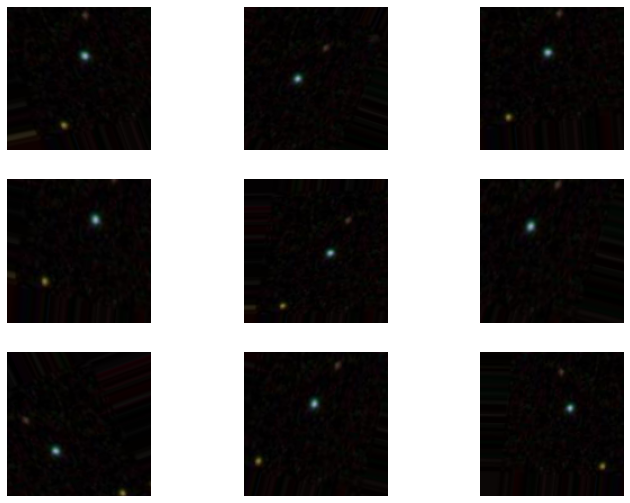

In [ ]:
gen_flow = default_datagen(data)
plot_augmentation(gen_flow, data, n_rows=3, n_cols=3)

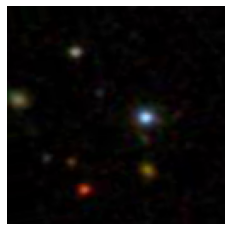

In [ ]:
image = next(gen_flow).astype(int)
plt.axis('off')
plt.imshow(image[0])